In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # mu layer
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # logvar layer

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [ ]:

# Convolutional VAE for better image handling
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 512)
        self.decoder = nn.Sequential(
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar



In [ ]:
# Loss function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss (Binary Cross Entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss

def conv_vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss for convolutional VAE
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss

# Training function
def train_vae(model, train_loader, optimizer, epoch, device, use_conv=False):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)

        if use_conv:
            loss = conv_vae_loss(recon_batch, data, mu, logvar)
        else:
            loss = vae_loss(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Generate new samples
def generate_samples(model, num_samples, latent_dim, device):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z)
        return samples

# Visualize results
def visualize_results(model, test_loader, device, num_samples=8, use_conv=False):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:num_samples].to(device)

        recon_batch, _, _ = model(data)

        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_samples, figsize=(12, 4))

        for i in range(num_samples):
            # Original
            if use_conv:
                axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
                axes[1, i].imshow(recon_batch[i].cpu().squeeze(), cmap='gray')
            else:
                axes[0, i].imshow(data[i].cpu().view(28, 28), cmap='gray')
                axes[1, i].imshow(recon_batch[i].cpu().view(28, 28), cmap='gray')

            axes[0, i].axis('off')
            axes[1, i].axis('off')

        axes[0, 0].set_ylabel('Original')
        axes[1, 0].set_ylabel('Reconstructed')
        plt.tight_layout()
        plt.show()

# Main training script
def main():
    # Hyperparameters
    batch_size = 128
    epochs = 20
    learning_rate = 1e-3
    latent_dim = 20

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data loading
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Choose model type
    use_conv = True  # Set to False for fully connected VAE

    if use_conv:
        model = ConvVAE(latent_dim=latent_dim).to(device)
    else:
        model = VAE(latent_dim=latent_dim).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(1, epochs + 1):
        train_vae(model, train_loader, optimizer, epoch, device, use_conv)

        # Visualize results every few epochs
        if epoch % 5 == 0:
            visualize_results(model, test_loader, device, use_conv=use_conv)

    # Generate new samples
    print("Generating new samples...")
    samples = generate_samples(model, 64, latent_dim, device)

    # Plot generated samples
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i in range(64):
        row, col = i // 8, i % 8
        if use_conv:
            axes[row, col].imshow(samples[i].cpu().squeeze(), cmap='gray')
        else:
            axes[row, col].imshow(samples[i].cpu().view(28, 28), cmap='gray')
        axes[row, col].axis('off')

    plt.suptitle('Generated Samples')
    plt.tight_layout()
    plt.show()

Train Epoch: 1 [0/60000 (0%)]	Loss: 560.817261
Train Epoch: 1 [12800/60000 (21%)]	Loss: 198.755859
Train Epoch: 1 [25600/60000 (43%)]	Loss: 157.058456
Train Epoch: 1 [38400/60000 (64%)]	Loss: 128.119415
Train Epoch: 1 [51200/60000 (85%)]	Loss: 122.880753
====> Epoch: 1 Average loss: 163.5479
Train Epoch: 2 [0/60000 (0%)]	Loss: 119.510704
Train Epoch: 2 [12800/60000 (21%)]	Loss: 119.600143
Train Epoch: 2 [25600/60000 (43%)]	Loss: 112.567680
Train Epoch: 2 [38400/60000 (64%)]	Loss: 106.956367
Train Epoch: 2 [51200/60000 (85%)]	Loss: 110.049637
====> Epoch: 2 Average loss: 111.1908
Train Epoch: 3 [0/60000 (0%)]	Loss: 109.111618
Train Epoch: 3 [12800/60000 (21%)]	Loss: 107.508209
Train Epoch: 3 [25600/60000 (43%)]	Loss: 107.017693
Train Epoch: 3 [38400/60000 (64%)]	Loss: 101.326141
Train Epoch: 3 [51200/60000 (85%)]	Loss: 101.532059
====> Epoch: 3 Average loss: 105.9805
Train Epoch: 4 [0/60000 (0%)]	Loss: 103.093124
Train Epoch: 4 [12800/60000 (21%)]	Loss: 101.202538
Train Epoch: 4 [25600/

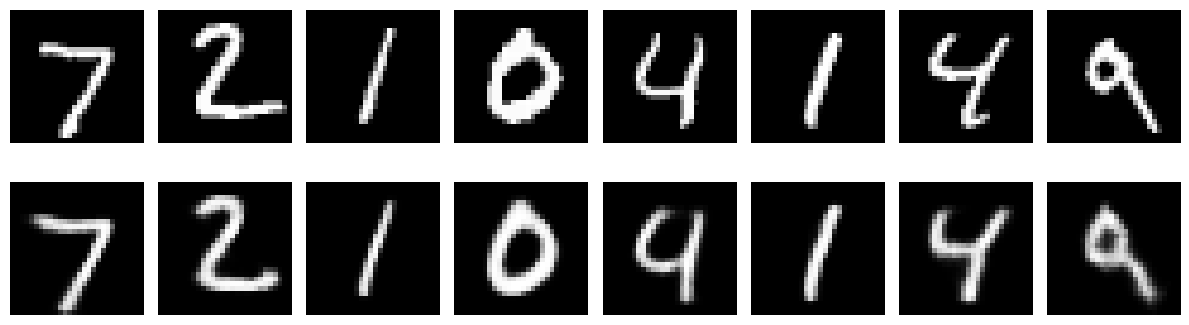

Train Epoch: 6 [0/60000 (0%)]	Loss: 104.225189
Train Epoch: 6 [12800/60000 (21%)]	Loss: 101.359474
Train Epoch: 6 [25600/60000 (43%)]	Loss: 100.564713
Train Epoch: 6 [38400/60000 (64%)]	Loss: 101.679352
Train Epoch: 6 [51200/60000 (85%)]	Loss: 100.083649
====> Epoch: 6 Average loss: 101.1217
Train Epoch: 7 [0/60000 (0%)]	Loss: 99.058487
Train Epoch: 7 [12800/60000 (21%)]	Loss: 98.028839
Train Epoch: 7 [25600/60000 (43%)]	Loss: 100.853302
Train Epoch: 7 [38400/60000 (64%)]	Loss: 101.075844
Train Epoch: 7 [51200/60000 (85%)]	Loss: 99.961441
====> Epoch: 7 Average loss: 100.4607
Train Epoch: 8 [0/60000 (0%)]	Loss: 100.132820
Train Epoch: 8 [12800/60000 (21%)]	Loss: 99.049500
Train Epoch: 8 [25600/60000 (43%)]	Loss: 104.367706
Train Epoch: 8 [38400/60000 (64%)]	Loss: 97.799385
Train Epoch: 8 [51200/60000 (85%)]	Loss: 103.771545
====> Epoch: 8 Average loss: 99.8277
Train Epoch: 9 [0/60000 (0%)]	Loss: 100.522560
Train Epoch: 9 [12800/60000 (21%)]	Loss: 99.177986
Train Epoch: 9 [25600/60000 (

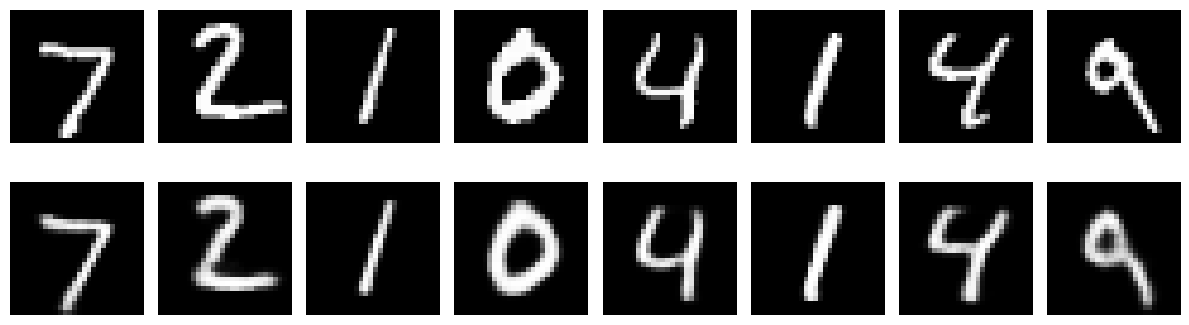

Train Epoch: 11 [0/60000 (0%)]	Loss: 96.556549
Train Epoch: 11 [12800/60000 (21%)]	Loss: 96.818588
Train Epoch: 11 [25600/60000 (43%)]	Loss: 100.045448
Train Epoch: 11 [38400/60000 (64%)]	Loss: 99.305519
Train Epoch: 11 [51200/60000 (85%)]	Loss: 101.909760
====> Epoch: 11 Average loss: 98.7371
Train Epoch: 12 [0/60000 (0%)]	Loss: 95.588928
Train Epoch: 12 [12800/60000 (21%)]	Loss: 97.676208
Train Epoch: 12 [25600/60000 (43%)]	Loss: 101.535309
Train Epoch: 12 [38400/60000 (64%)]	Loss: 101.137962
Train Epoch: 12 [51200/60000 (85%)]	Loss: 101.632446
====> Epoch: 12 Average loss: 98.3975
Train Epoch: 13 [0/60000 (0%)]	Loss: 96.672974
Train Epoch: 13 [12800/60000 (21%)]	Loss: 97.939644
Train Epoch: 13 [25600/60000 (43%)]	Loss: 99.074272
Train Epoch: 13 [38400/60000 (64%)]	Loss: 95.105820
Train Epoch: 13 [51200/60000 (85%)]	Loss: 96.193970
====> Epoch: 13 Average loss: 98.1399
Train Epoch: 14 [0/60000 (0%)]	Loss: 100.163322
Train Epoch: 14 [12800/60000 (21%)]	Loss: 99.124748
Train Epoch: 14 

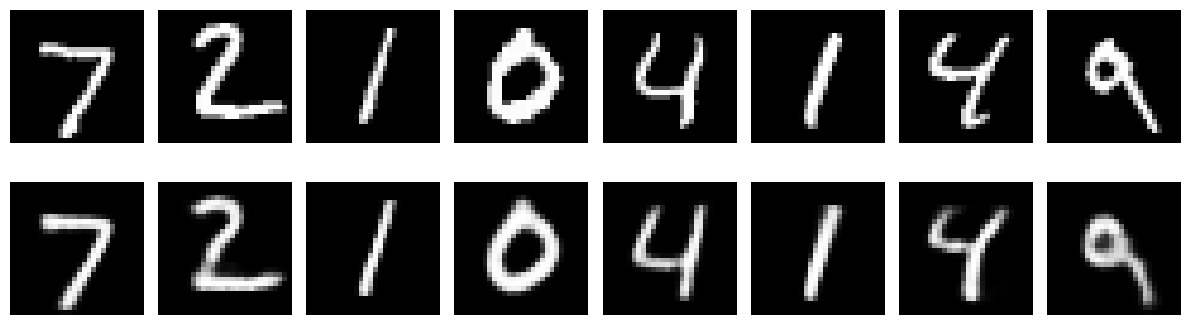

Train Epoch: 16 [0/60000 (0%)]	Loss: 95.325127
Train Epoch: 16 [12800/60000 (21%)]	Loss: 100.997589
Train Epoch: 16 [25600/60000 (43%)]	Loss: 98.849182
Train Epoch: 16 [38400/60000 (64%)]	Loss: 97.612617
Train Epoch: 16 [51200/60000 (85%)]	Loss: 97.696732
====> Epoch: 16 Average loss: 97.5046
Train Epoch: 17 [0/60000 (0%)]	Loss: 99.126801
Train Epoch: 17 [12800/60000 (21%)]	Loss: 94.148148
Train Epoch: 17 [25600/60000 (43%)]	Loss: 97.976913
Train Epoch: 17 [38400/60000 (64%)]	Loss: 96.397682
Train Epoch: 17 [51200/60000 (85%)]	Loss: 95.588608
====> Epoch: 17 Average loss: 97.2883
Train Epoch: 18 [0/60000 (0%)]	Loss: 95.843964
Train Epoch: 18 [12800/60000 (21%)]	Loss: 96.758911
Train Epoch: 18 [25600/60000 (43%)]	Loss: 96.206299
Train Epoch: 18 [38400/60000 (64%)]	Loss: 98.766106
Train Epoch: 18 [51200/60000 (85%)]	Loss: 99.745850
====> Epoch: 18 Average loss: 97.1199
Train Epoch: 19 [0/60000 (0%)]	Loss: 94.344986
Train Epoch: 19 [12800/60000 (21%)]	Loss: 95.889999
Train Epoch: 19 [2560

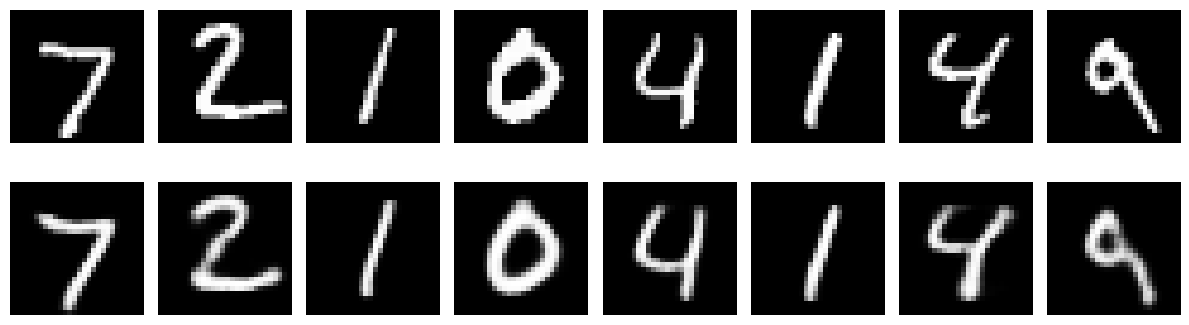

Generating new samples...


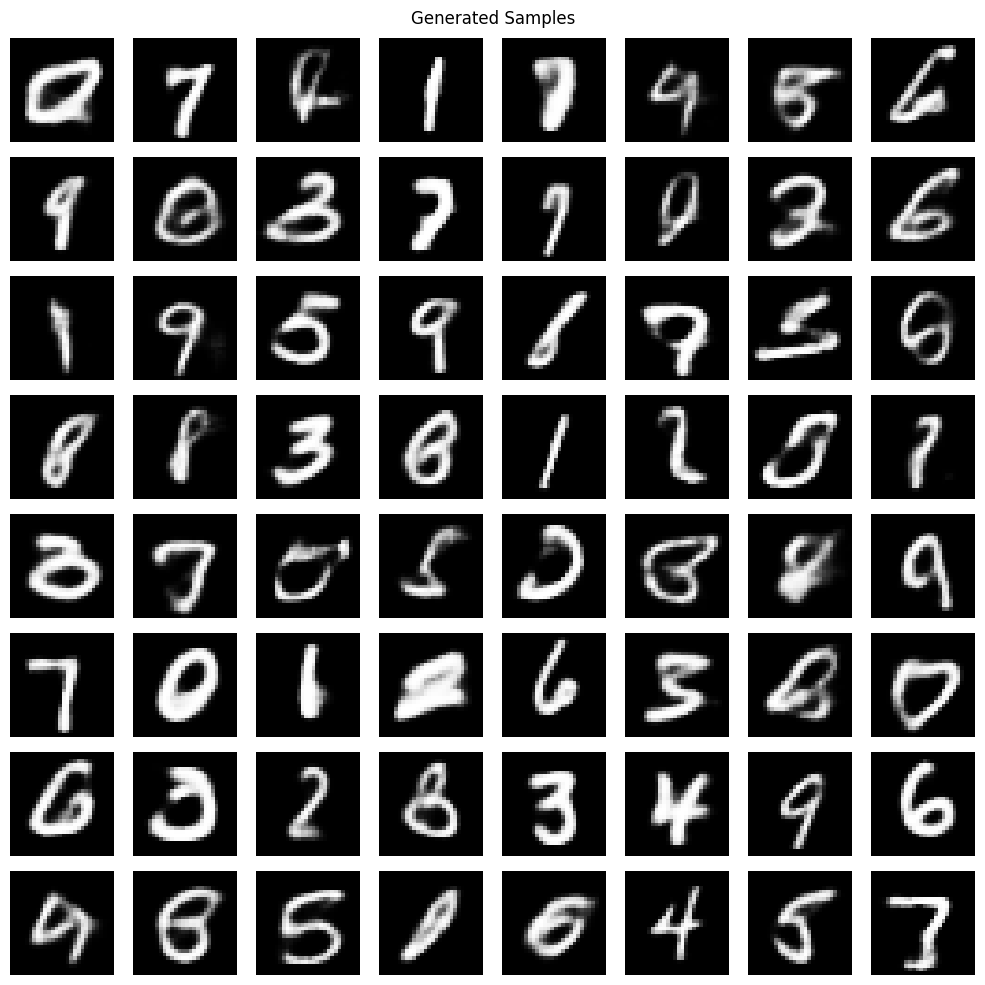

In [ ]:
main()